In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import tqdm
#import utils
import ampds_preprocessing
from time import time
import pickle
%load_ext autoreload
%autoreload 2


Bad key "text.kerning_factor" on line 4 in
/home/camilo/anaconda3/envs/nilm/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


### Convertir base en dataframe
AMPds se puede bajar desde https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/FIE0S4. Dentro del zip esta el archivo AMPds2.h5

In [2]:
# path_h5  = 'ampds2.h5'
# df = ampds_preprocessing.get_df_per_day(path_h5)

In [3]:
# with open('arrays/df.pickle', 'wb') as fp:
#     pickle.dump(df, fp)

In [4]:
with open('arrays/df.pickle', 'rb') as fp:
    df = pickle.load(fp)

In [5]:
#df = df.rename(columns=ampds_preprocessing.FULL_NAME)

In [6]:
# divide los dataframes entre agregados y desagregados
individual = df.loc[:, df.columns.get_level_values('name')!='WHE']
aggregate = df.loc[:, df.columns.get_level_values('name')=='WHE']

In [7]:
n_days, _ = aggregate.columns.levshape
f'Se tienen {n_days} días de datos'

'Se tienen 726 días de datos'

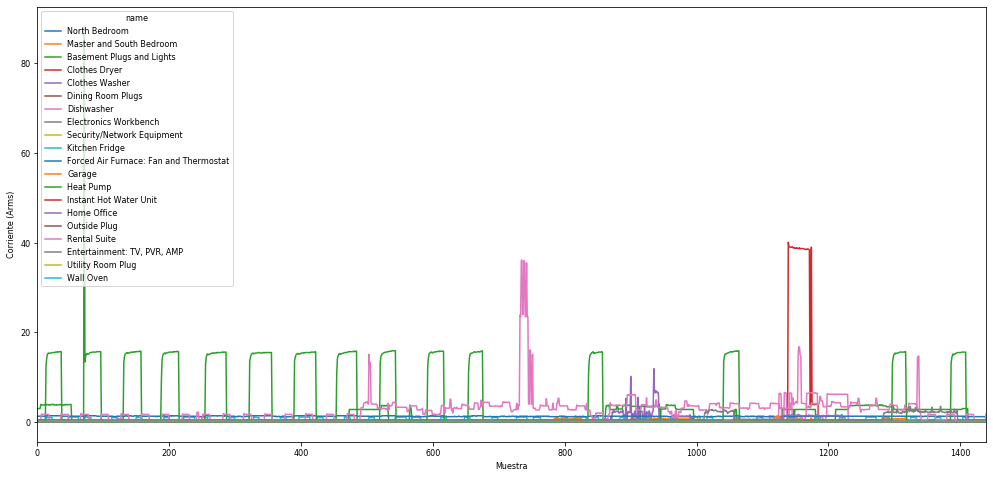

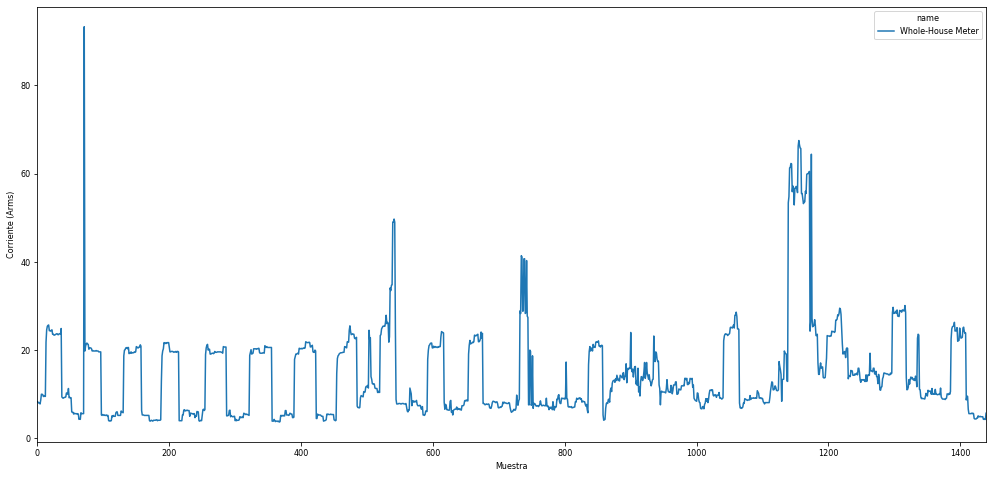

In [8]:
rcParams['font.style'] = 'normal'
rcParams['font.size'] = 8
rcParams['font.weight'] = 'normal'
individual[0].rename(columns=ampds_preprocessing.FULL_NAME).plot(figsize=(17,8))
plt.xlabel('Muestra')
plt.ylabel('Corriente (Arms)')
#plt.title('Señales de corriente')
plt.savefig('images/ampd_individual')
aggregate[0].rename(columns=ampds_preprocessing.FULL_NAME).plot(figsize=(17,8))

plt.xlabel('Muestra')
plt.ylabel('Corriente (Arms)')
#plt.title('Señales de corriente')
plt.savefig('images/ampd_agg')

In [9]:
individual.shape

(1440, 14520)

In [10]:
DAYS_TO_TRAIN = 580
DAYS_TO_EVAL = 135
D = individual.loc[:, 0:DAYS_TO_TRAIN].to_numpy()
D[D<0] = 0
X = aggregate.loc[:, 715-DAYS_TO_EVAL:715].to_numpy()
X[X<0] = 0
np.save('arrays/X.npy', X)
np.save('arrays/D.npy', D)

In [11]:
D.shape, X.shape

((1440, 11620), (1440, 136))

# Problema a resolver
Se intenta resolver un problema similar al del paper https://arxiv.org/pdf/1704.07308.pdf. El problema es el siguiente:
$$min_A ||X - DA||_{F}^2$$

$$\text{ s.t. $A_{i,j}>0$ $\forall i,j$}$$

- $D$ (Matriz de diccionario): Es una matriz cuyas columnas son las bases del consumo de energeia electrico (se espera poder estimar el consumo sea una combinación lineal de estos vectores).

- $X$ (Matriz de datos a proyectar): Es una matriz en la que cada columna representa el consumo electrico de que se quiere proyectar sobre las columnas de $D$.

## Implementación
Se implementa mediante apgd. El tipo de aceleración que se elige es ADAM.

In [12]:
# from apgd import adam_pgd
# t1 = time()
# A_simple, cost, losses_simple = adam_pgd(D, X, max_iter=70_000)
# t2 = time()
# print(f'Tiempo: {t2-t1:.1f}')

In [13]:
# losses_apgd = np.array(losses_apgd)
# np.save('arrays/A_simple.npy', A_apgd)
# np.save('arrays/losses_simple.npy', losses_apgd)

In [14]:
A_simple = np.load('arrays/A_simple.npy')
losses_simple = np.load('arrays/losses_simple.npy')

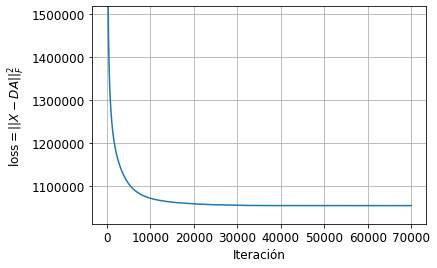

In [15]:
rcParams['font.style'] = 'normal'
rcParams['font.size'] = 12
rcParams['font.weight'] = 'normal'
plt.figure()
plt.plot(losses_simple)
plt.ylim((1055476.62*0.96, 1265412.12*1.2))
plt.grid(True)
plt.xlabel('Iteración')
plt.ylabel(r'loss$={||X-DA||_F^2}$')
plt.savefig('images/loss_sin_regularizacion.png', bbox_inches='tight')

In [16]:
A = A_simple
sum_current_total = X.sum(axis=0)

names = list(ampds_preprocessing.FULL_NAME.keys())
names.remove('WHE')
sum_current_elec = np.empty((len(names), X.shape[1]))
for i, s in enumerate(names):
    # Mascara para tener solo el electrodomestico de interes
    mask = (individual.columns.get_level_values('name')==s)[0:A.shape[0]]

    # A enmascarado poniendo a 0 todos los coeficientes que no son del
    # electrodomestico de interes
    A_mask = A * mask[:,np.newaxis]
    serie_elec = D @ A_mask

    # Suma de corriente consumida por dia para este electrodomestico
    sum_current_elec[i] = serie_elec.sum(axis=0)

In [17]:
columns = pd.RangeIndex(715-DAYS_TO_EVAL,716)

sumas_corriente = pd.DataFrame(sum_current_elec, index=names, columns=columns)
sumas_corriente = sumas_corriente.sum(axis=1)#.rename(ampds_preprocessing.FULL_NAME)
ground_truth = individual.loc[:, DAYS_TO_TRAIN+1:715].sum(axis=0).unstack(level=0)
ground_truth = ground_truth.sum(axis=1)#.rename(ampds_preprocessing.FULL_NAME)

In [18]:
full_names = list(ampds_preprocessing.FULL_NAME.values())
full_names.remove('Whole-House Meter')
full_names = list(enumerate(full_names))
full_names = list(map(lambda x:str(x[0]+1)+'-'+x[1], full_names))

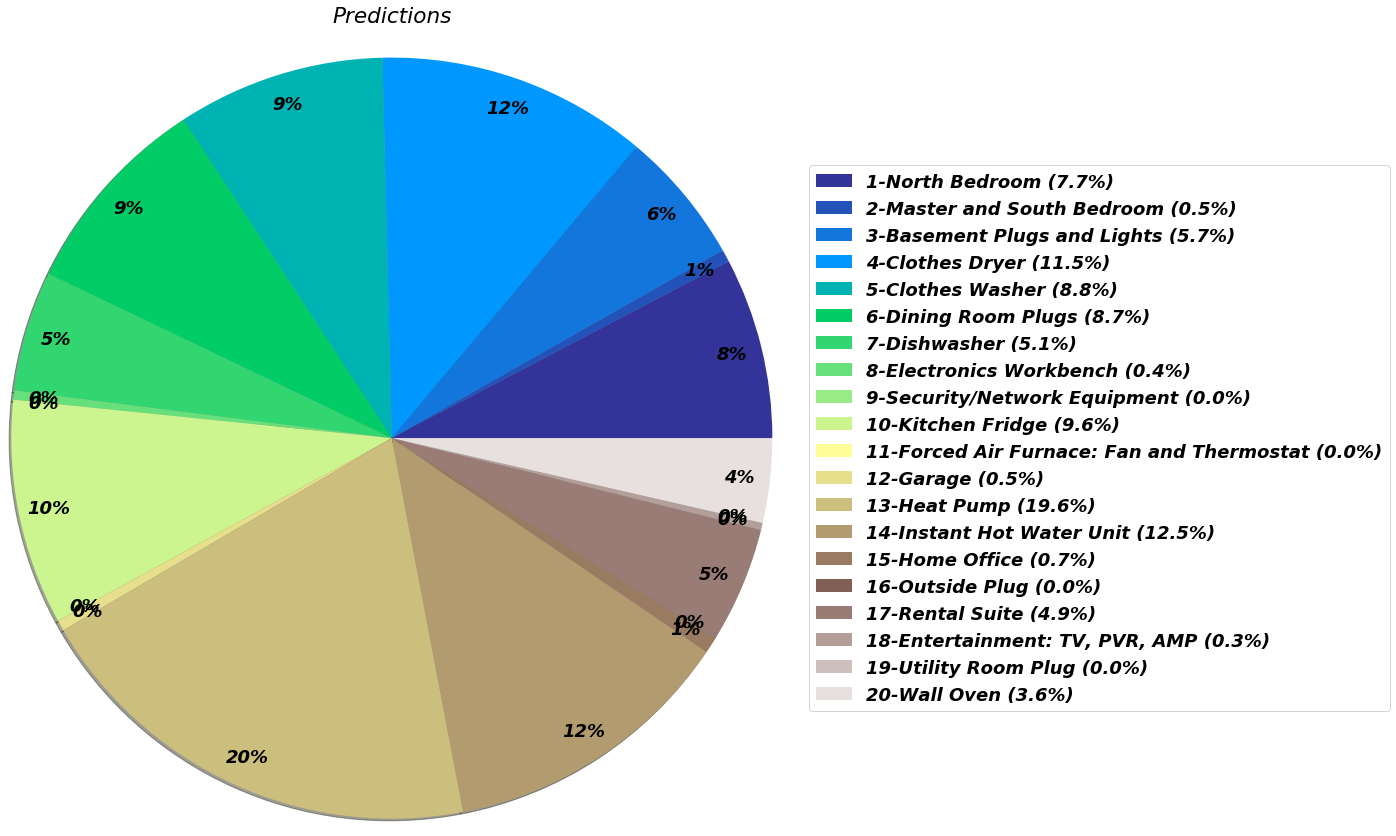

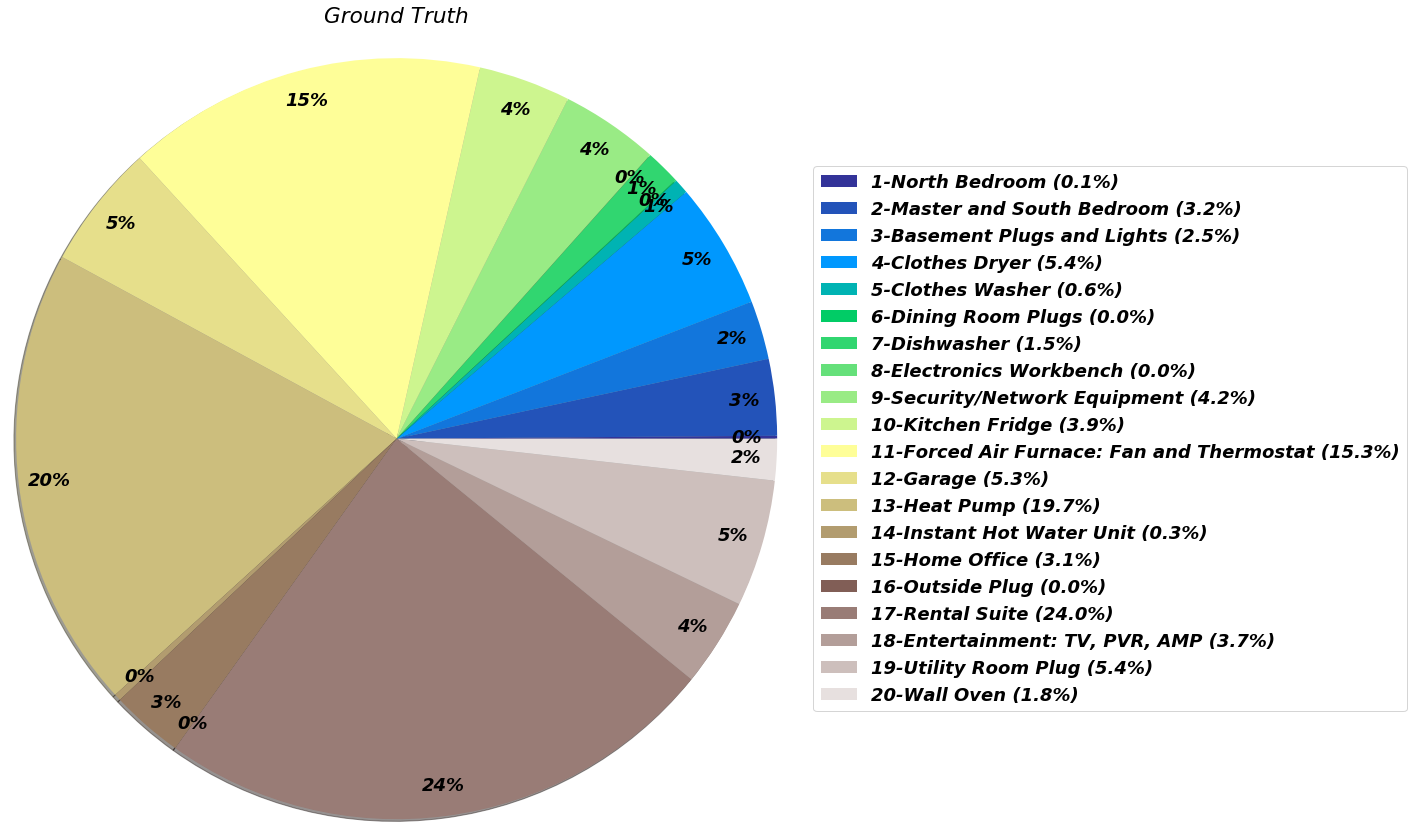

In [19]:
def add_percentege_to_names(x, full_names):
    tot = x.sum()
    percentages = list(map(lambda x:f' ({x/tot*100:.1f}%)', x))
    names = zip(full_names, percentages)
    names = list(map(lambda x:x[0]+x[1], names))
    return names

def plot_pie(x):
    rcParams['font.style'] = 'oblique'
    rcParams['font.size'] = 18
    rcParams['font.weight'] = 'heavy'

    fig1, ax1 = plt.subplots(figsize=(6, 5))

    theme = plt.get_cmap('terrain')
    ax1.set_prop_cycle("color", [theme(1. * i / len(x)) for i in range(len(x))])
    
    ax1.pie(x, 
            autopct='%1.0f%%', 
            radius=3.5, 
            shadow=True, 
            pctdistance=0.92,)
    names = add_percentege_to_names(x, full_names)
    ax1.legend(names,
               loc="center left",
               bbox_to_anchor=(2, 0, 0.5, 1))

plot_pie(sumas_corriente.to_numpy())
#plt.title('Predictions')
plt.title('Predictions', pad=(280))
plt.savefig('images/prediction_prob_sencillo.png', bbox_inches='tight')

plot_pie(ground_truth.to_numpy())
plt.title('Ground Truth', pad=(280))
plt.savefig('images/ground_truth_prob_sencillo.png', bbox_inches='tight')

In [20]:
X.shape

(1440, 136)

In [21]:
X_pred = D @ A_simple
X_pred.shape

(1440, 136)

In [22]:
def DE(X, X_pred):
    km = np.prod(X.shape)
    de = np.sum(np.abs(X-X_pred))/km
    return de

In [23]:
f'DE = {DE(X, X_pred):.2f}'

'DE = 1.31'

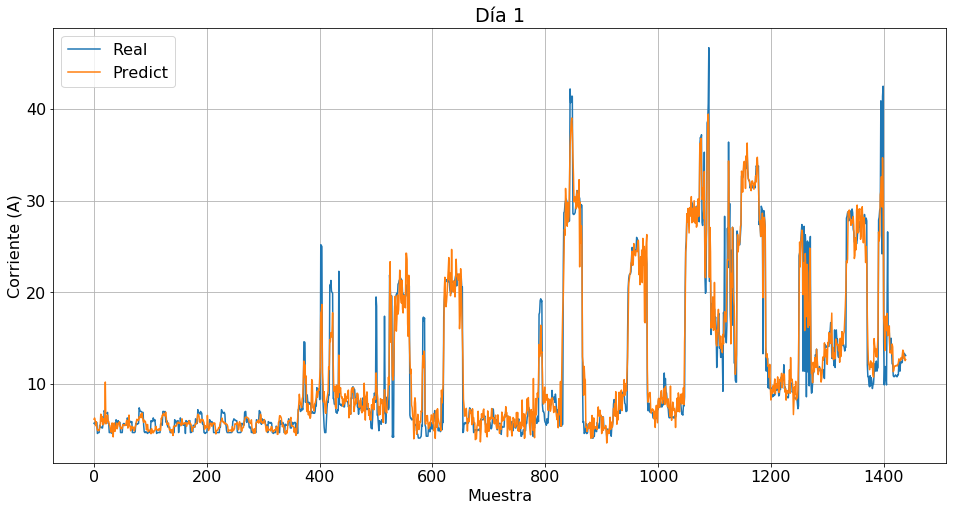

In [24]:
rcParams['font.style'] = 'normal'
rcParams['font.size'] = 16
rcParams['font.weight'] = 'normal'
dia_ejemplo = 1
plt.figure(figsize=(16, 8))
plt.plot(X[:, dia_ejemplo], label='Real')
plt.plot(X_pred[:, dia_ejemplo], label='Predict')
plt.legend()
plt.xlabel('Muestra')
plt.ylabel('Corriente (A)')
plt.grid(True)
plt.title(f'Día {dia_ejemplo}')
plt.savefig('images/plot_agregado_sin_regularizacion.png')